# SHACL Validation on Object Store

Ocean Info Hub SHACL validation on S3(minio) objects

It should be noted here that SHACL validation is not a service OIH offers.  Rather, 
the validation is a capacity that the OIH architectural approach facilities.  Further
this validation follows W3C recommendations as describted in 
[https://www.w3.org/TR/shacl/](https://www.w3.org/TR/shacl/).

## Flow

* get an object (use the dask notebook)
* process the object against OIH SHACL shapes


In [6]:
from pyshacl import validate
from os import path
from pandas import json_normalize
import pandas as pd
import json
import rdflib
# import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
def label_status (row):
  result = row['http://www.w3.org/ns/shacl#resultSeverity']
  if result == "nan":
    return "NA" 
  elif "Warning" in result:
    return "Warning"
  elif "Violation" in result:
    return "Violation"  
  else:
    return result

def source_shape (row):
  result = row['http://www.w3.org/ns/shacl#sourceShape']
  if type(result) is list: 
    return result[0]['@id']
  else:
    return "NA"


## Gleaner Data

First lets load up some of the data Gleaner has collected.  This is just simple data graph objects and not any graphs or other processed products from Gleaner. 

In [8]:
# Set up our S3FileSystem object
import s3fs 

oss = s3fs.S3FileSystem(
      anon=True,
      key="",
      secret="",
      client_kwargs = {"endpoint_url":"https://oss.collaborium.io"}
   )

In [9]:
# Create the Dask tasks..   created..  not run..  
import json
import dask, boto3
import dask.dataframe as dd

@dask.delayed()
def read_a_file(fn):
    # or preferably open in text mode and json.load from the file
    with oss.open(fn, 'rb') as f:
        #return json.loads(f.read().replace('\n',' '))
        return json.loads(f.read().decode("ascii", "ignore").replace('\n',' '))

# List of buckets to work with..   if you don't know them, you could print out above
buckets = ['gleaner/summoned/oceanexperts'] 
filenames = []

for d in range(len(buckets)):
  print("indexing {}".format(buckets[d]))
  f = oss.ls(buckets[d])
  filenames += f

#filenames = oss.cat('gleaner/summoned/opentopo', recursive=True)
output = [read_a_file(f) for f in filenames]
print(len(filenames))
# print(filenames)

indexing gleaner/summoned/oceanexperts
502


In [10]:
%%time 


gldf = pd.DataFrame(columns=["id", "status", "shape"])

for ndx in range(len(output)):
# for ndx in range(10):
    
  if "/.jsonld" not in filenames[ndx] :
    try:
      jld = output[ndx].compute()  ## Now pull from dask..   In REAL version, move this logic into Dask!  to get the parallel approach
    except:
      print(filenames[ndx])
      print("Doc has bad encoding")

    jd = json.dumps(jld, sort_keys=True, indent=4)
        
    try:
      conforms, v_graph, v_text = validate(jd, 
                shacl_graph='./oih_learning.ttl', 
                data_graph_format="json-ld", 
                shape_graph_format="ttl", 
                inference='none', 
                serialize_report_graph="json-ld")
      
      gd = v_graph.decode("ascii") 
      df = pd.DataFrame(json.loads(gd))
      conforms = df["http://www.w3.org/ns/shacl#conforms"]
      tf = conforms[0][0]['@value']

      if "False" in str(tf):
        df['http://www.w3.org/ns/shacl#resultSeverity'] = df['http://www.w3.org/ns/shacl#resultSeverity'].astype(str)
        df['ID'] = filenames[ndx] #  'Object:{}'.format(ndx) 
        df['Status'] = df.apply (lambda row: label_status(row), axis=1)
        df['Shape'] = df.apply (lambda row: source_shape(row), axis=1)

        data = [df["ID"], df["Status"], df['Shape']]
        headers = ["id", "status", "shape"]
        df3 = pd.concat(data, axis=1, keys=headers)
        gldf = gldf.append(df3, ignore_index=True)
      elif "True" in str(tf):
        df['ID'] = filenames[ndx] #  'Object:{}'.format(ndx) 
        df['Status'] = "Valid"
        df['Shape'] = "AllPassed"

        data = [df["ID"], df["Status"], df['Shape']]
        headers = ["id", "status", "shape"]
        df3 = pd.concat(data, axis=1, keys=headers)
        gldf = gldf.append(df3, ignore_index=True)  
    
#       print("------------------")
#       print(conforms)
#       print(v_graph)
#       print(v_text)

    except:
      print("ERROR")
      df = pd.DataFrame()
      df['ID'] = filenames[ndx] #  'Object:{}'.format(ndx) 
      df['Status'] = "ErrorProcessing"
      df['Shape'] = "ErrorProcessing"

      data = [df["ID"], df["Status"], df['Shape']]
      headers = ["id", "status", "shape"]
      df3 = pd.concat(data, axis=1, keys=headers)
      gldf = gldf.append(df3, ignore_index=True)
      print("PySHACL decode error: {}",format(filenames[ndx]))



ERROR
PySHACL decode error: {} gleaner/summoned/oceanexperts/00eae339a41708c68c51a2902b443dc8bd5fbaaf.jsonld
ERROR
PySHACL decode error: {} gleaner/summoned/oceanexperts/014dbf631db7b1221656e4ac8d6ffe86743a2a3c.jsonld
ERROR
PySHACL decode error: {} gleaner/summoned/oceanexperts/019224fb3174aace8e1378285d7b7717cd2b34aa.jsonld
ERROR
PySHACL decode error: {} gleaner/summoned/oceanexperts/0223a997319c102be7c1c0af40b4a997b1e8dbb8.jsonld
ERROR
PySHACL decode error: {} gleaner/summoned/oceanexperts/022ac35a670a36a31f85c69fb39895ff77069ca8.jsonld
ERROR
PySHACL decode error: {} gleaner/summoned/oceanexperts/02d9e1dc59370fdc208a493875ee95c4983fd6e2.jsonld
ERROR
PySHACL decode error: {} gleaner/summoned/oceanexperts/04465d22c71d4f680170aa424d7d0b7fc6ce3da0.jsonld
ERROR
PySHACL decode error: {} gleaner/summoned/oceanexperts/0493f473b6c3b7879eceb4a8db4a148cecd11c63.jsonld
ERROR
PySHACL decode error: {} gleaner/summoned/oceanexperts/04ae6d1f95df008a25b5fd575ed641fd285ebc03.jsonld
ERROR
PySHACL decod

In [17]:
gldf.info() 
gldf.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      481 non-null    object
 1   status  481 non-null    object
 2   shape   481 non-null    object
dtypes: object(3)
memory usage: 11.4+ KB


,id,status,shape
0,gleaner/summoned/oceanexperts/00eae339a41708c6...,Valid,AllPassed
1,gleaner/summoned/oceanexperts/014dbf631db7b122...,Valid,AllPassed
2,gleaner/summoned/oceanexperts/019224fb3174aace...,Valid,AllPassed
3,gleaner/summoned/oceanexperts/0223a997319c102b...,Valid,AllPassed
4,gleaner/summoned/oceanexperts/022ac35a670a36a3...,Valid,AllPassed


In [18]:
pd.value_counts(gldf['shape'])

AllPassed    481
Name: shape, dtype: int64

(array([  0., 100., 200., 300., 400., 500., 600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

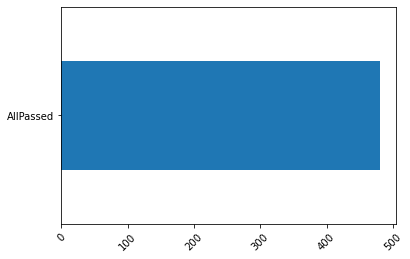

In [19]:
pd.value_counts(gldf['shape']).plot.barh()
plt.xticks(rotation=45)